In this file the possibility of clustering readme files was explored. In addition, I explored the patterns in README files.

# Useful libraries and functions

In [1]:
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from time import time
import matplotlib.pyplot as plt
from CBTTextProcessing import *

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
from collections import defaultdict
from time import time
import pandas as pd
from sklearn import metrics

evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X, vectorizer, name=None, n_runs=5, top_n_keywords=3):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    keyword_storage = []

    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        if len(set(km.labels_)) > 1:
            scores["Silhouette Coefficient"].append(
                metrics.silhouette_score(X, km.labels_, sample_size=2000)
            )
            scores["Calinski-Harabasz Index"].append(
                metrics.calinski_harabasz_score(X, km.labels_)
            )
            scores["Davies-Bouldin Index"].append(
                metrics.davies_bouldin_score(X, km.labels_)
            )

            order_centroids = km.cluster_centers_.argsort()[:, ::-1]
            terms = vectorizer.get_feature_names_out()
            keywords = ["Cluster {}: {}".format(i, ", ".join([terms[ind] for ind in order_centroids[i, :top_n_keywords]]))
                        for i in range(km.n_clusters)]
            keyword_storage.append(keywords)

    train_times = np.asarray(train_times)
    evaluations.append({
        "estimator": name,
        "train_time_mean": train_times.mean(),
        "train_time_std": train_times.std(),
        **{key: np.mean(val) for key, val in scores.items()},
        **{key + '_std': np.std(val) for key, val in scores.items()}
    })

    # Printing summary results after all runs
    print(f"\n{name} Clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s")
    for score_name, score_values in scores.items():
        print(f"{score_name}: {np.mean(score_values):.3f} ± {np.std(score_values):.3f}")

    # Print keyword summaries
    for run_idx, keywords in enumerate(keyword_storage, 1):
        print(f"\nRun {run_idx} Keywords:")
        for keyword in keywords:
            print(keyword)

# Getting and Preprocessing data

In [3]:
documents = []
headers = []

progress = IntProgress(min=0, max=1010)
display(progress)


for id in range(0, 1010):
    file_name = id_to_file_name(id)
    header, content = get_text_from_file(file_name)
    content = preprocess_text(header, content)
    headers.append(header)
    documents.append(content)
    progress.value += 1

IntProgress(value=0, max=1010)

Here I am trying to create artificial centroids for our unsupervised clustering.

In [4]:
groups = ['ispf', 'racf', 'rexx', 'cobol', 'asm', 'assembler', 'z/os', 'os 360', 'os 390', 'book', 'article', 'game', 'vse', 'tso', 'linux']

In [5]:
for group in groups:
    headers.append(group)
    document_group = 500 * (group + ' ')
    documents.append(document_group)

In [6]:
vectorizer = TfidfVectorizer(
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(documents)
X = X_tfidf.toarray()

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.328 s
n_samples: 1025, n_features: 22829


# Using K-means clustering to see how clustering performs on data

In [7]:
progress = IntProgress(min=3, max=40)
progress.value = 3 
display(progress)

for i in range(3, 40):
    try:
        kmeans = KMeans(
            n_clusters=i,
            max_iter=100,
            n_init=10,
            random_state=123,  
        )
        fit_and_evaluate(kmeans, X, vectorizer, name=f"KMeans on tf-idf vectors with {i} clusters")
    except ValueError as e:
        print(f"Error with {i} clusters: {e}")
    finally:
        progress.value += 1

IntProgress(value=3, max=40, min=3)


KMeans on tf-idf vectors with 3 clusters Clustering done in 7.24 ± 1.05 s
Silhouette Coefficient: 0.024 ± 0.002
Calinski-Harabasz Index: 18.626 ± 0.498
Davies-Bouldin Index: 5.402 ± 2.750

Run 1 Keywords:
Cluster 0: program, tso, command
Cluster 1: file, contains, ispf
Cluster 2: pds, file, program

Run 2 Keywords:
Cluster 0: william, smith, california
Cluster 1: program, file, member
Cluster 2: pds, file, program

Run 3 Keywords:
Cluster 0: file, program, contains
Cluster 1: tso, command, program
Cluster 2: pds, file, program

Run 4 Keywords:
Cluster 0: file, program, contains
Cluster 1: pds, file, program
Cluster 2: tso, program, command

Run 5 Keywords:
Cluster 0: program, file, member
Cluster 1: pds, file, program
Cluster 2: ispf, william, file

KMeans on tf-idf vectors with 4 clusters Clustering done in 13.08 ± 2.25 s
Silhouette Coefficient: 0.026 ± 0.001
Calinski-Harabasz Index: 14.549 ± 0.418
Davies-Bouldin Index: 7.012 ± 0.702

Run 1 Keywords:
Cluster 0: tso, command, gt
Clust

## Plotting results of clustering

In [8]:
silhouette_scores = [value['Silhouette Coefficient'] for value in evaluations]
db_scores = [value['Davies-Bouldin Index'] for value in evaluations]
ch_scores = [value['Calinski-Harabasz Index'] for value in evaluations]

In [9]:
clusters = range(3, 40)

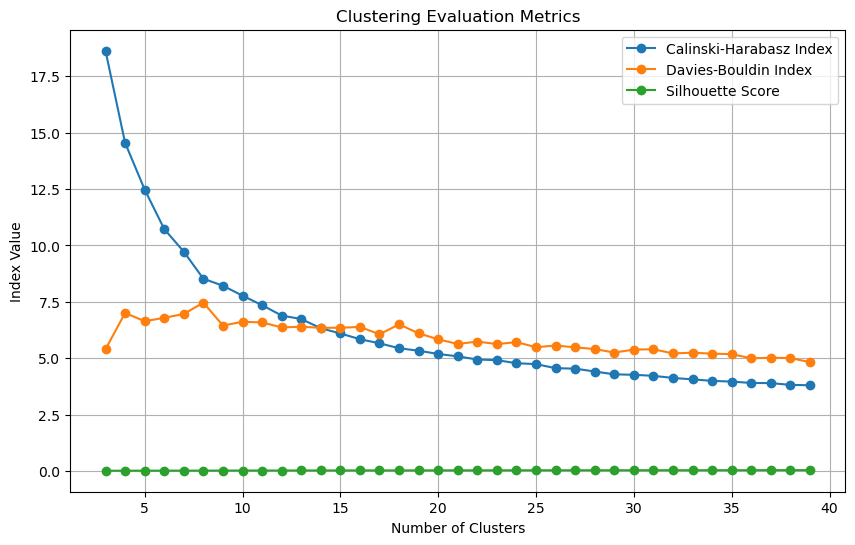

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(clusters, ch_scores, label='Calinski-Harabasz Index', marker='o')
plt.plot(clusters, db_scores, label='Davies-Bouldin Index', marker='o')
plt.plot(clusters, silhouette_scores, label='Silhouette Score', marker='o')

plt.xlabel('Number of Clusters')
plt.ylabel('Index Value')
plt.title('Clustering Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

We see that Silhouette metric is not that clear, so let's try to plot it in a separate graph 

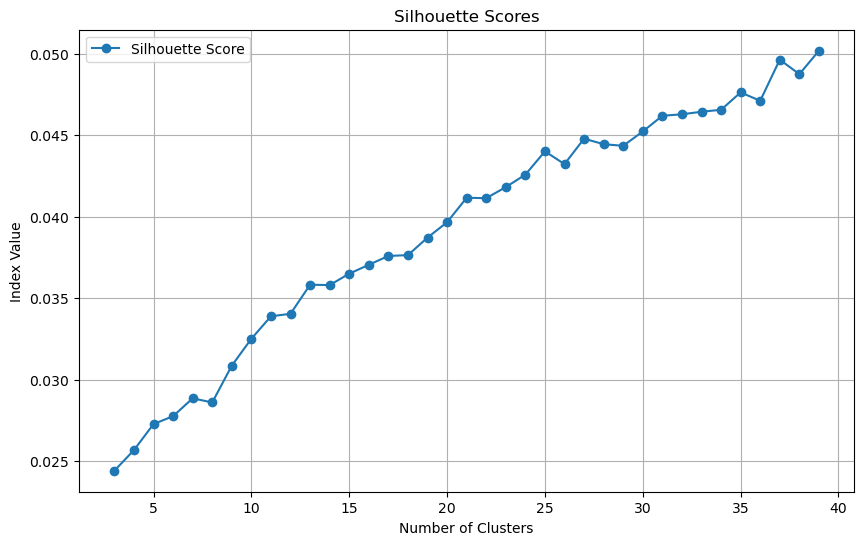

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(clusters, silhouette_scores, label='Silhouette Score', marker='o')

plt.xlabel('Number of Clusters')
plt.ylabel('Index Value')
plt.title('Silhouette Scores')
plt.legend()
plt.grid(True)
plt.show()

We can see a trend of increasing Silhouette score with increasing the number of clusters, indicating that the separation among clusters improves.
However, we can also see that the Calinski-Harabasz Index decreases with more clusters, suggesting diminishing returns in cluster compactness and separation as the number of clusters increases. Additionally, the Davies-Bouldin Index generally trends downward, indicating that the clustering becomes more distinct and less similar as the number of clusters increases.
the CH Index decreases with more clusters, it suggests that adding more clusters does not significantly improve the distinctiveness or compactness of the clusters. This might indicate that an optimal number of clusters has been exceeded, and additional clusters are introducing redundancy or splitting well-defined clusters into smaller, less distinct ones.

 Silhouette score being close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters. One way to improve this is by increasing the number of clusters. Another ways are preprocessing data in a different way or using different clustering techniques. 

In [16]:
km = KMeans(
    n_clusters=38,
    max_iter=500,
    n_init=15,
    random_state=123,
)

In [17]:
labels = km.fit_predict(X)

In [23]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

In [25]:
cluster_centers = km.cluster_centers_
cluster_centers_tsne = tsne.fit_transform(cluster_centers)

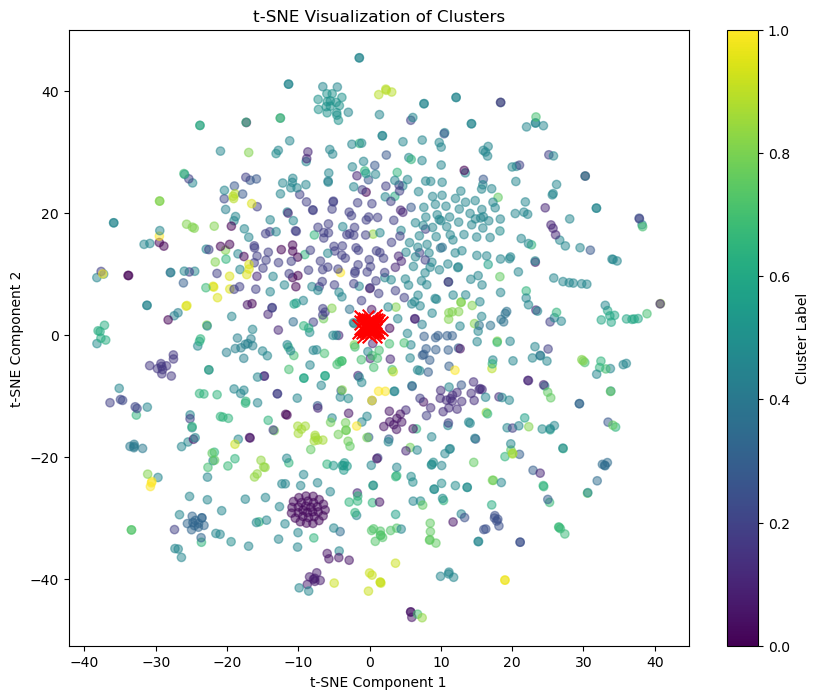

In [26]:
labels = km.labels_

# Plot the t-SNE reduced data points, colored by their cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers_tsne[:, 0], cluster_centers_tsne[:, 1], s=200, c='red', marker='x')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')
plt.colorbar(label='Cluster Label')
plt.show()

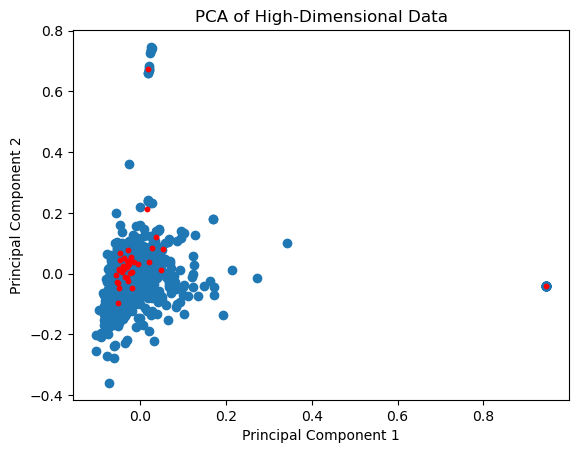

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot the reduced data
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

cluster_centers_reduced = pca.transform(km.cluster_centers_)
plt.scatter(cluster_centers_reduced[:, 0], cluster_centers_reduced[:, 1], s=10, c='red')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of High-Dimensional Data')
plt.show()

Ideally, different clusters should appear as distinct groupings of points. However, the PCA plot shows significant overlap among the clusters, suggesting that the data points are not well-separated in these two dimensions.

# Conclusion

We can see that unsupervised learning is not a good choice for clustering readme files due to significant overlap between readme files' content, so let's try using another approach: LLMs for classification.